In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# label 정의

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [ ]:
# 구글 드라이브에 저장된 fashion-mnist csv 파일 불러오기
!gdown --id 1lo-tPwidDyA9uAOUbCkpHetwEuiBxcyp
!unzip fashion-mnist-csv.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1lo-tPwidDyA9uAOUbCkpHetwEuiBxcyp
To: /content/fashion-mnist-csv.zip
100% 36.3M/36.3M [00:01<00:00, 32.9MB/s]
Archive:  fashion-mnist-csv.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  


In [ ]:
# 커스텀 데이터 셋 만들기[+]

class CustomImageDataset(Dataset):
    def __init__(self, csv, transform=None):
        self.data = pd.read_csv(csv).to_numpy()
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        label = self.data[idx, 0]
        image = self.data[idx, 1:].reshape(28,28).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label




In [ ]:
# 데이터 만들기[+]
D_train = CustomImageDataset('fashion-mnist_train.csv',  transform=ToTensor())
train_loader = DataLoader(D_train, batch_size=64, shuffle=True)
train_loader_iter = iter(train_loader)

D_test = CustomImageDataset('fashion-mnist_test.csv', transform=ToTensor())
test_loader = DataLoader(D_test, batch_size=100, shuffle=False)
test_loader_iter = iter(test_loader)

In [ ]:

# train function[+]
def train_with_train_acc(model, criterion, optimizer, epochs, hist):
    for e in range(epochs):
        model.train()

        train_loss = 0.0

        for i, (X_batched, y_batched) in enumerate(train_loader):
            # zerograd, inference, loss, backward, step
            # 학습데이터를 gpu로 올리기
            X_batched = X_batched.to(device)
            y_batched = y_batched.to(device)

            optimizer.zero_grad()
            score = model(X_batched)
            loss = criterion(score, y_batched)
            loss.backward()
            optimizer.step()

            train_loss += loss

        model.eval()
        with torch.no_grad():
            corr = 0
            for i, (X_batched, y_batched) in enumerate(train_loader):
                # 입력데이터를 gpu로 올리기
                X_batched = X_batched.to(device)
                y_batched = y_batched.to(device)

                score = model(X_batched)
                softmax_score = torch.exp(score)
                y_pred = torch.argmax(softmax_score, dim=-1)
                corr += (y_pred == y_batched).sum()
            train_acc = corr.item()/len(D_train)
            hist['train_acc'].append(train_acc)

            corr = 0
            for i, (X_batched, y_batched) in enumerate(test_loader):
                X_batched = X_batched.to(device)
                y_batched = y_batched.to(device)

                score = model(X_batched)
                softmax_score = torch.exp(score)
                y_pred = torch.argmax(softmax_score, dim=-1)
                corr += (y_pred == y_batched).sum()
            test_acc = corr.item()/len(D_test)
            hist['test_acc'].append(test_acc)

            avg_train_loss = train_loss / len(train_loader)
            print(f"EPOCH: {e}, AVG TRAIN LOSS: {avg_train_loss.item():.6f}, TRAIN ACC.:{train_acc:.3f}, TEST ACC.:{test_acc:.3f}")

In [ ]:
# model define

model = torch.nn.Sequential(
    ######################################
    torch.nn.Flatten(),
    torch.nn.Linear(784, 784),
    torch.nn.ReLU(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.LogSoftmax(dim=-1)
    ######################################
)

# 모델을 gpu로 올리기
model.to(device)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=784, bias=True)
  (2): ReLU()
  (3): Linear(in_features=784, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
  (6): LogSoftmax(dim=-1)
)

In [ ]:
# optimizer and loss
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# train model
hist_wo_do = {'train_acc':[], 'test_acc':[]}
train_with_train_acc(model, criterion, optimizer, 50, hist_wo_do)

EPOCH: 0, AVG TRAIN LOSS: 0.497669, TRAIN ACC.:0.849, TEST ACC.:0.846
EPOCH: 1, AVG TRAIN LOSS: 0.361313, TRAIN ACC.:0.880, TEST ACC.:0.870
EPOCH: 2, AVG TRAIN LOSS: 0.329035, TRAIN ACC.:0.885, TEST ACC.:0.873
EPOCH: 3, AVG TRAIN LOSS: 0.301434, TRAIN ACC.:0.900, TEST ACC.:0.886
EPOCH: 4, AVG TRAIN LOSS: 0.282858, TRAIN ACC.:0.902, TEST ACC.:0.885
EPOCH: 5, AVG TRAIN LOSS: 0.266978, TRAIN ACC.:0.901, TEST ACC.:0.883
EPOCH: 6, AVG TRAIN LOSS: 0.252633, TRAIN ACC.:0.907, TEST ACC.:0.882
EPOCH: 7, AVG TRAIN LOSS: 0.241084, TRAIN ACC.:0.899, TEST ACC.:0.878
EPOCH: 8, AVG TRAIN LOSS: 0.230324, TRAIN ACC.:0.909, TEST ACC.:0.879
EPOCH: 9, AVG TRAIN LOSS: 0.220140, TRAIN ACC.:0.923, TEST ACC.:0.897
EPOCH: 10, AVG TRAIN LOSS: 0.210637, TRAIN ACC.:0.913, TEST ACC.:0.879
EPOCH: 11, AVG TRAIN LOSS: 0.200283, TRAIN ACC.:0.926, TEST ACC.:0.894
EPOCH: 12, AVG TRAIN LOSS: 0.193750, TRAIN ACC.:0.932, TEST ACC.:0.897
EPOCH: 13, AVG TRAIN LOSS: 0.182907, TRAIN ACC.:0.936, TEST ACC.:0.898
EPOCH: 14, AVG T

In [ ]:
# model define
model_do = torch.nn.Sequential(
    ######################################
    torch.nn.Flatten(),
    torch.nn.Linear(784, 784),
    torch.nn.BatchNorm1d(784), # 배치 정규화 실시
    torch.nn.ReLU(),
    torch.nn.Linear(784, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.LogSoftmax(dim=-1)
    ######################################
)
model_do.to(device)

# 배치 정규화
# 각 노드로 이동하면서 데이터의 분포가 정규분포-> 일반 분포로 변형
# 각 노드를 이동하면서 일반 분포를 다시 정규화 한 후 넘겨줌.

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=784, bias=True)
  (2): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=784, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=10, bias=True)
  (8): LogSoftmax(dim=-1)
)

In [ ]:
# optimizer and loss
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_do.parameters(), lr=0.001)

# train model
hist_with_do = {'train_acc':[], 'test_acc':[]}
train_with_train_acc(model_do, criterion, optimizer, 50, hist_with_do)

EPOCH: 0, AVG TRAIN LOSS: 0.438504, TRAIN ACC.:0.862, TEST ACC.:0.853
EPOCH: 1, AVG TRAIN LOSS: 0.334305, TRAIN ACC.:0.893, TEST ACC.:0.883
EPOCH: 2, AVG TRAIN LOSS: 0.300218, TRAIN ACC.:0.900, TEST ACC.:0.882
EPOCH: 3, AVG TRAIN LOSS: 0.272562, TRAIN ACC.:0.892, TEST ACC.:0.875
EPOCH: 4, AVG TRAIN LOSS: 0.251871, TRAIN ACC.:0.921, TEST ACC.:0.894
EPOCH: 5, AVG TRAIN LOSS: 0.232964, TRAIN ACC.:0.926, TEST ACC.:0.895
EPOCH: 6, AVG TRAIN LOSS: 0.214537, TRAIN ACC.:0.935, TEST ACC.:0.899
EPOCH: 7, AVG TRAIN LOSS: 0.197698, TRAIN ACC.:0.930, TEST ACC.:0.890
EPOCH: 8, AVG TRAIN LOSS: 0.185508, TRAIN ACC.:0.938, TEST ACC.:0.899
EPOCH: 9, AVG TRAIN LOSS: 0.168853, TRAIN ACC.:0.942, TEST ACC.:0.892
EPOCH: 10, AVG TRAIN LOSS: 0.161266, TRAIN ACC.:0.937, TEST ACC.:0.886
EPOCH: 11, AVG TRAIN LOSS: 0.150564, TRAIN ACC.:0.956, TEST ACC.:0.899
EPOCH: 12, AVG TRAIN LOSS: 0.138921, TRAIN ACC.:0.952, TEST ACC.:0.900
EPOCH: 13, AVG TRAIN LOSS: 0.128832, TRAIN ACC.:0.959, TEST ACC.:0.900
EPOCH: 14, AVG T

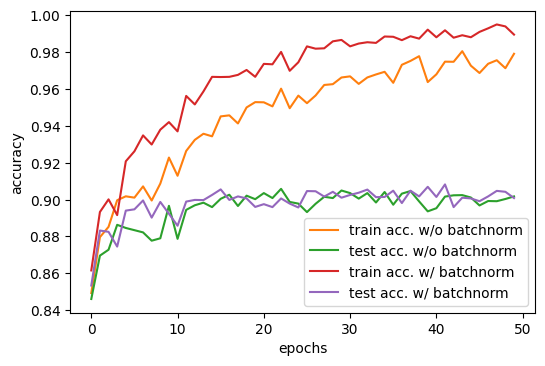

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(hist_wo_do['train_acc'], label='train acc. w/o batchnorm', color='C1')
ax.plot(hist_wo_do['test_acc'], label='test acc. w/o batchnorm', color='C2')

ax.plot(hist_with_do['train_acc'], label='train acc. w/ batchnorm', color='C3')
ax.plot(hist_with_do['test_acc'], label='test acc. w/ batchnorm', color='C4')

ax.legend()

ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

plt.show()